# Sentence Transformer Embedding based Topics Modelling and Prediction

Importing Libraries
--

In [1]:
from pre_process import *

Loading Libraries...Just a moment please!...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading dataset
--

In [2]:
path = "/Users/gurpreetbedi/Downloads/Neural/Indeed_local/source_data/"

In [3]:
art_train = load_data(f"{path}article.json")
art_test = load_data(f"{path}pred_article.json")

art_test["cont_title"] = art_test["contentTitle"] + " " +art_test["content"]
art_train["cont_title"] = art_train["contentTitle"] + " " +art_train["content"]

art_test = remove_hyperlinks_html_tags(art_test, "cont_title")
art_train = remove_hyperlinks_html_tags(art_train, "cont_title")

Shape of pre-processed data
--

In [4]:
print("After pre-processing the raw data: ")
print(f'Shape of the article from taining corpus: {art_train.shape}')
print(f'Shape of the article from test corpus: {art_test.shape}')

After pre-processing the raw data: 
Shape of the article from taining corpus: (13639, 8)
Shape of the article from test corpus: (1417, 7)


Load sentence ransformer embeddings
--

In [5]:
content = list(art_train["cont_title"])
title = list(art_train['contentTitle'])

In [6]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
sent_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [7]:
print(f'Shape of Sentence Transformer embeddings of the articles from training corpus : {art_train.shape}')

Shape of Sentence Transformer embeddings of the articles from training corpus : (13639, 8)


Perform dimensionality reduction and document clustering
--

In [10]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       metric='cosine')

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

umap_data = umap_model.fit_transform(sent_embeddings)
cluster = hdbscan_model.fit(umap_data)

In [11]:
print(f"The number of unqiue topics from HDBSCAN model: {len(np.unique(cluster.labels_))}")

The number of unqiue topics from HDBSCAN model: 169


Save the model for future reference
--

In [75]:
joblib.dump(umap_model, f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/umap_model_{len(np.unique(cluster.labels_))}.sav")
joblib.dump(hdbscan_model, f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/hdbscan_model_{len(np.unique(cluster.labels_))}.sav")

['/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/hdbscan_model_254.sav']

Different Visualizations of Clustered data
--

8920 4719


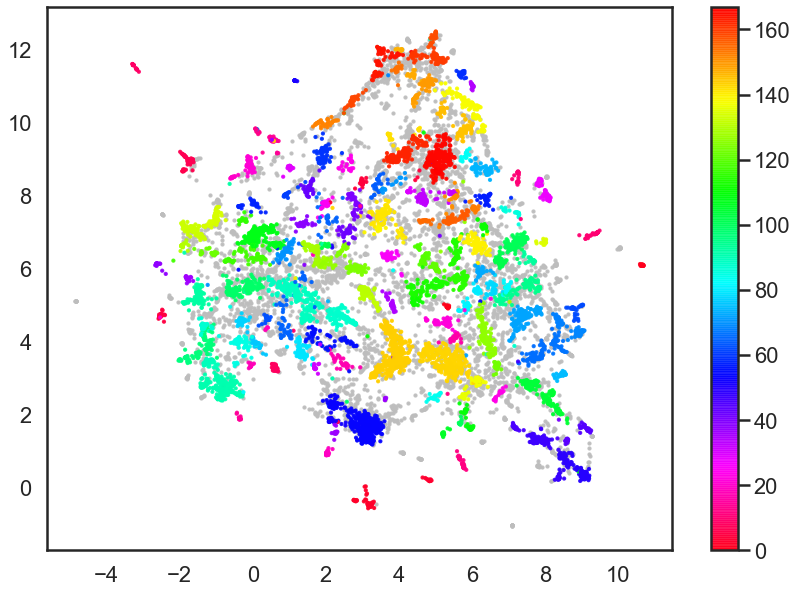

In [12]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(sent_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.9)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r', alpha=0.9)

print(len(clustered), len(outliers))
plt.colorbar()

Scatter plot to show points in space
--

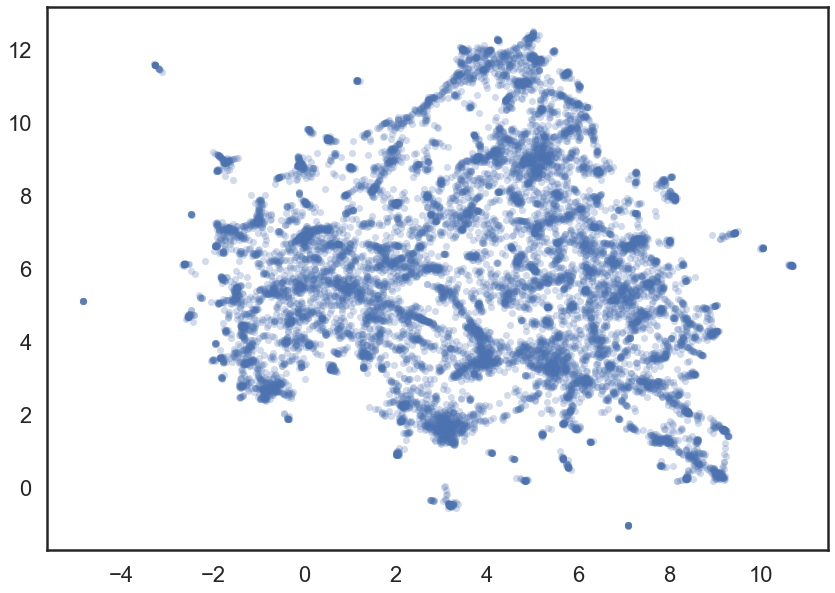

In [13]:
plt.scatter(*umap_data.T, s=50, linewidth=0, c='b', alpha=0.25)

Condensed Tree Plot from HDBSCAN
--

<AxesSubplot:ylabel='$\\lambda$ value'>

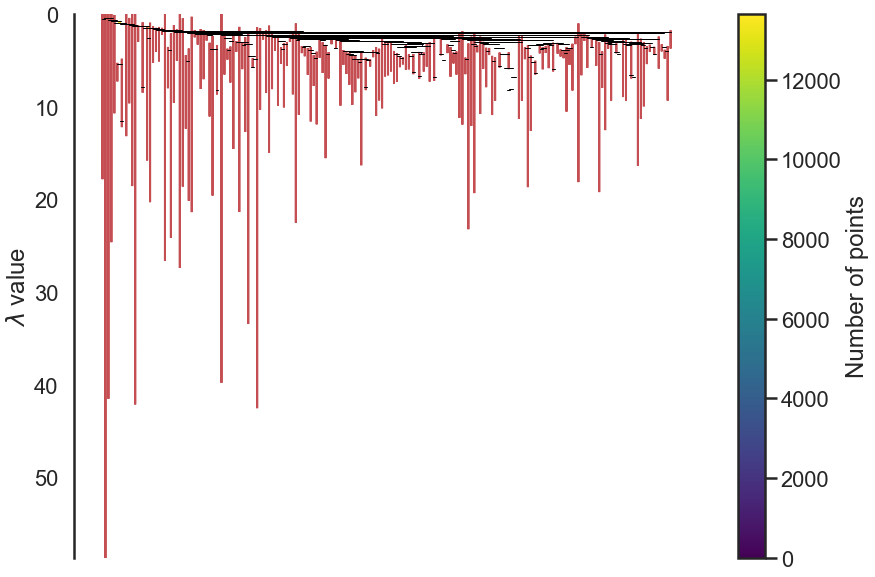

In [14]:
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("deep",8))

Soft Clustering of the topics in space
--

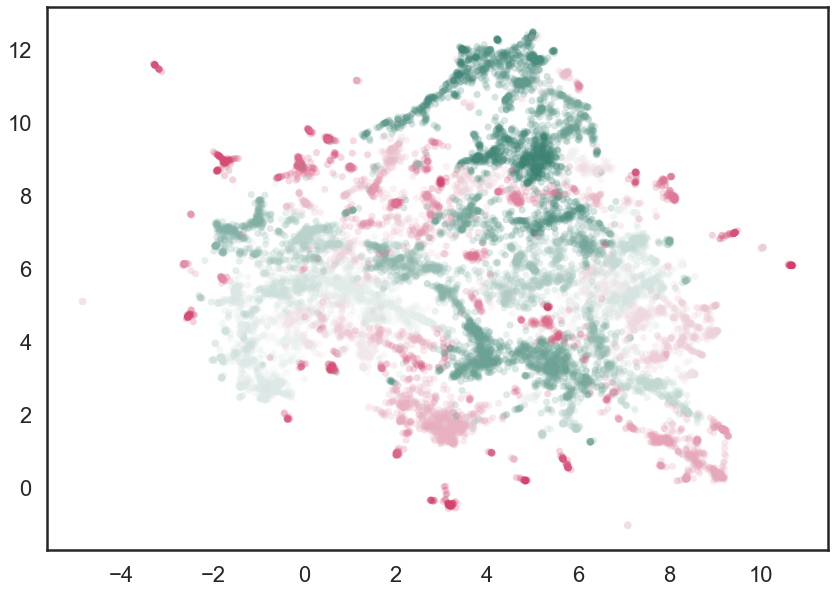

In [15]:
soft_clusters = hdbscan.all_points_membership_vectors(cluster)

color_palette = sns.diverging_palette(0, len(np.unique(clustered.labels)), n=len(np.unique(clustered.labels)))
cluster_colors = [color_palette[np.argmax(x)] for x in soft_clusters]

plt.scatter(*umap_data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

Assigning Labels from Clustering to the documents
--

In [16]:
docs_df = pd.DataFrame(content, columns=["Doc"])
docs_df['Title'] = title
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Topic based TF-IDF
--

In [17]:
def doc_tf_idf(documents, doc_length, ngram_range=(1,1)):
    """
    topic based TF-IDF to create dense clusters allowing for easily interpretable topics
    """
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    terms = count.transform(documents).toarray()
    words = np.sum(terms, axis=1)
    tf = terms.T/words
    sum_terms = np.sum(terms, axis=0)
    idf = np.log(doc_length/sum_terms).reshape(-1, 1)
    tf_idf = tf * idf
    return tf_idf, count
  
tf_idf, count = doc_tf_idf(docs_per_topic.Doc.values, doc_length=len(content), ngram_range=(1,2))

In [18]:
print(f"TF-IDF Shape: {tf_idf.shape}")

TF-IDF Shape: (2969974, 169)


Creating topic words from topic numbers
--

In [19]:
def get_top_n_words(tf_idf, count, docs_per_topic, n=20):
    """
    Get the top words per topic
    """      
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_10_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_10_words

def get_topic_sizes(df):
    """
    Get the document counts clustered for all the topics.
    """    
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index().rename({"Topic": "Topic", "Doc": "Doc_Count"}, axis='columns').sort_values("Doc_Count", ascending=False))
    return topic_sizes

top_10_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
topic_sizes = get_topic_sizes(docs_df)
topic_sizes.head(10)

Topic  Doc_Count
0       -1       4719
145    144        426
55      54        352
144    143        294
92      91        259
167    166        233
90      89        216
109    108        209
102    101        152
51      50        142

Top 4 topics with maximum size
--

In [20]:
top_10_words[144], top_10_words[54], top_10_words[143], top_10_words[91]

([('interview questions', 0.003925506590170565),
  ('sample answers', 0.0026903261225122654),
  ('answers', 0.0026768846740510893),
  ('java', 0.0024277922618297374),
  ('interviewer', 0.002413799446620847),
  ('question', 0.0022478769846632227),
  ('depth questions', 0.0022261155151597164),
  ('general questions', 0.0022055697060402667),
  ('sql', 0.0021557162398553016),
  ('sample', 0.002126524567053064)],
 [('resumes', 0.003329480725264072),
  ('summary', 0.003123279857590851),
  ('section', 0.0024613831802778176),
  ('chronological', 0.0023929816520184667),
  ('format', 0.002386570163518728),
  ('work experience', 0.002068537766874441),
  ('achievements', 0.0020188341669064584),
  ('awards', 0.001977419906338218),
  ('resume template', 0.00195497069976446),
  ('accomplishments', 0.0019220433216924934)],
 [('interviewer', 0.0034956173871255633),
  ('interviews', 0.0027227247473649734),
  ('interview questions', 0.0022871413395031443),
  ('question', 0.002183145984372814),
  ('interv

Heatmap for top 30 topics
--

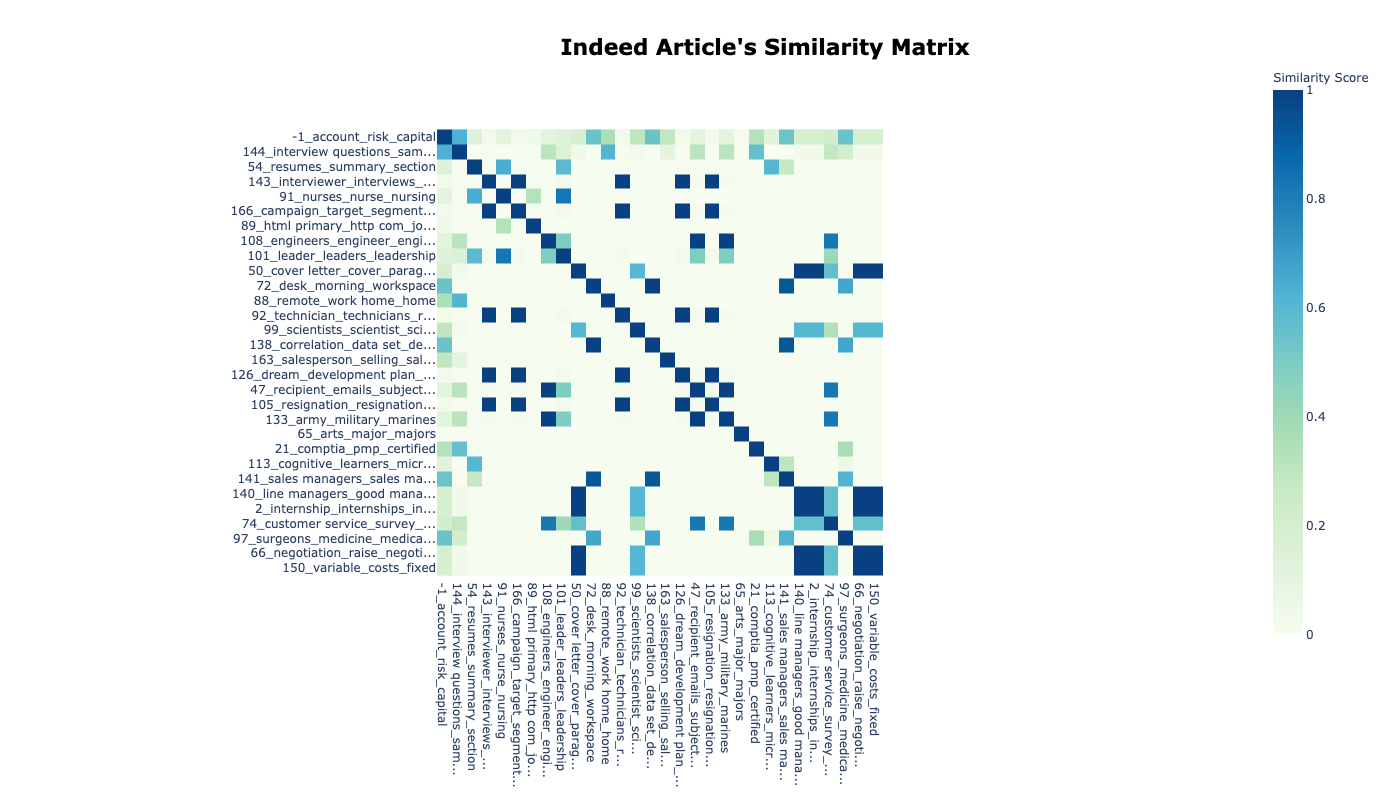

In [21]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()[:30]
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

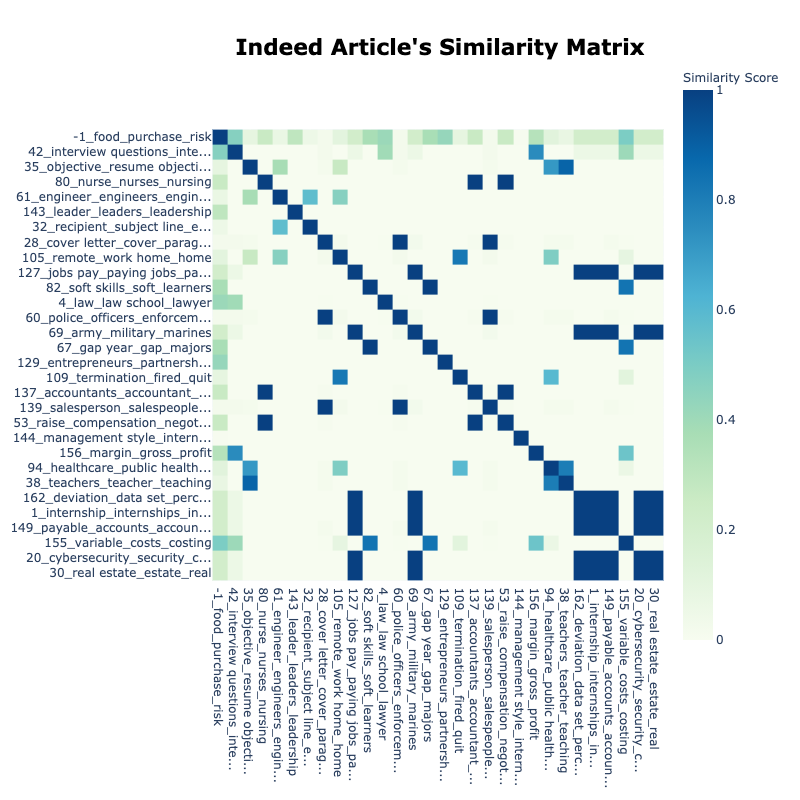

In [20]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (32).png") 

Heatmap for all topics
--

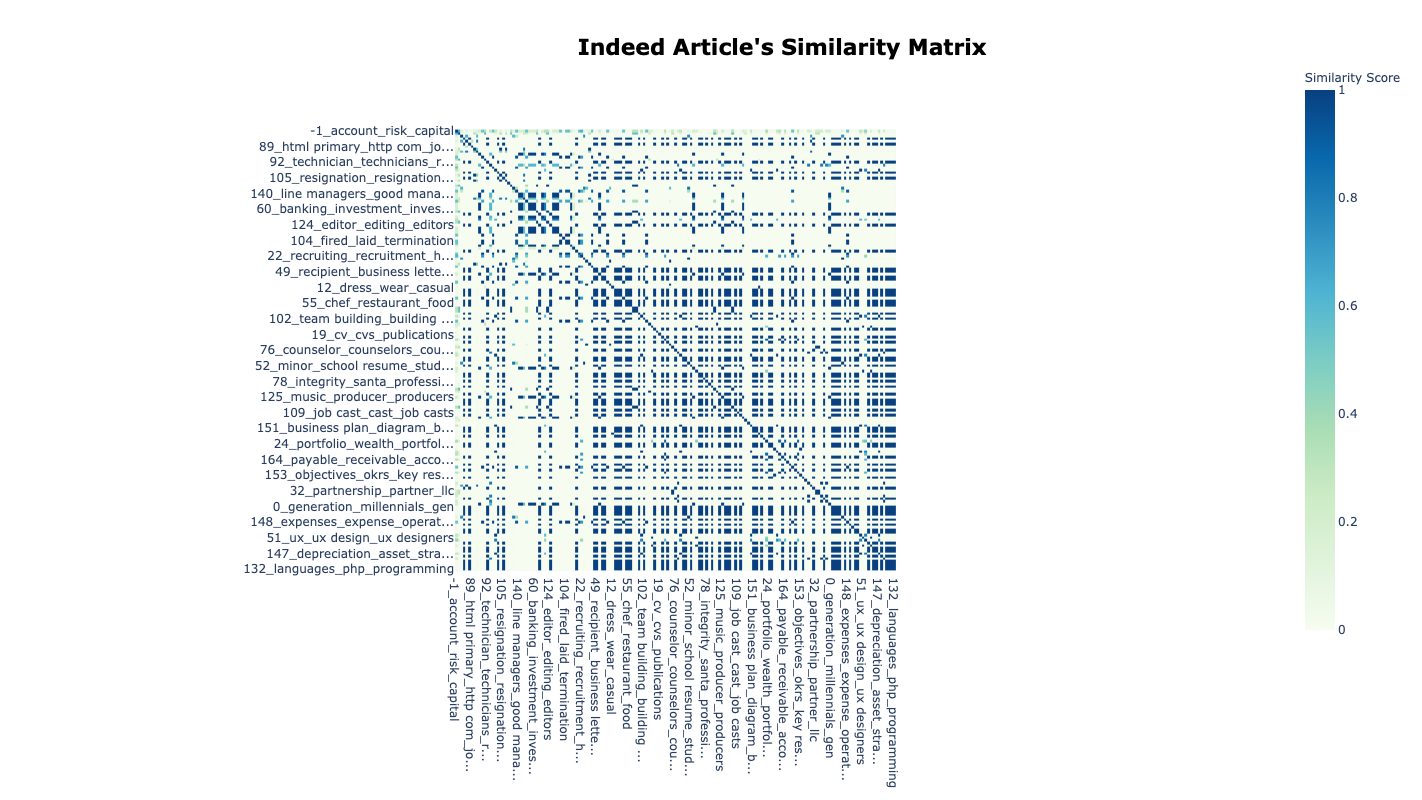

In [22]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

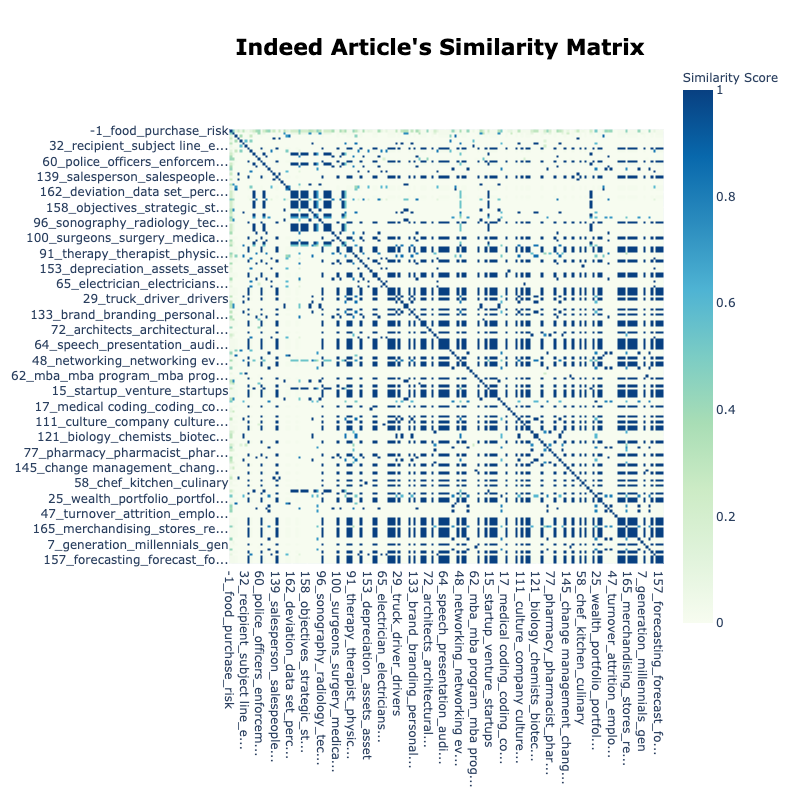

In [22]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (33).png") 

2-D Plotly Visualization of topics in Space
--

In [23]:
def get_colors(topics, topic_list):
    """
    Get the color marker for the topics inside the topics list
    """          
    if topics == -1:
        marker = ["#B0BEC5" for _ in topic_list[1:]]
    else:
        marker = ["red" if topic == topics else "#B0BEC5" for topic in topic_list[1:]]
    return [{'marker_color': [marker]}]   

def get_topic(topic):
    """
    Get a particular topic from all the topics
    """           
    return top_10_words[topic]

def get_topics():         
    """
    Get a all the topics in a dictionary
    """          
    return top_10_words

def get_topic_freq(topic= None):
    """
    Get document count per topic which will be the size of the topic
    """    
    if isinstance(topic, int):
        return topic_sizes[topic]
    else:
        return topic_sizes
    
def topic_visualization_fotmatting(df, topic_list, width, height):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """
    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"x": False, "y": False, "Topic": True, "Words": True, "Size": True})
    fig.update_traces(marker=dict(color="#7f91eb", line=dict(width=2, color='DarkSlateGrey'))) #"#B0BEC5"

    # Update hover order
    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Count: %{customdata[2]}"]))   
    
    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_colors(topic,topic_list)) for topic in topic_list[1:]]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
                        title={'text': "<b>Indeed's Intertopic Distance", 'y': .95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=22,color="Black")},
                        width=width,
                        height=height,
                        hoverlabel=dict(
                            bgcolor="white",
                            font_size=14,
                            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)


    fig.add_shape(type="line",
                  x0=sum(x_range)/2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range)/2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

In [24]:
def topics_viz_data(topics, width, height):
    """
    Creates Topic Visalization in 2D space. Each topic taking shape as the sice of the documents clustered in each topic
    """       
    topics = sorted(list(get_topics().keys()))
    frequencies = [topic_sizes[topic_sizes["Topic"]==topic]["Doc_Count"].values[0] for topic in topics]
    words = [" | ".join([word[0] for word in get_topic(topic)[:5]]) for topic in topics]

    indices = np.array([topics.index(topic) for topic in topics])

    embeddings = tf_idf[indices]
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings = umap.UMAP(n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embeddings)

    df = pd.DataFrame({"x": embeddings[1:, 0], "y": embeddings[1:, 1],
                       "Topic": topics[1:], "Words": words[1:], "Size": frequencies[1:]})
    fig = topic_visualization_fotmatting(df, topics, width, height)

    return fig, embeddings, df


In [25]:
def visualize_topics(topics = None, width = 1000, height = 1000):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """    
    fig,_,_= topics_viz_data(topics=topics,
                             width=width,
                             height=height)
    return fig

In [26]:
topics = docs_per_topic.Topic.tolist()
fig = visualize_topics(topics)

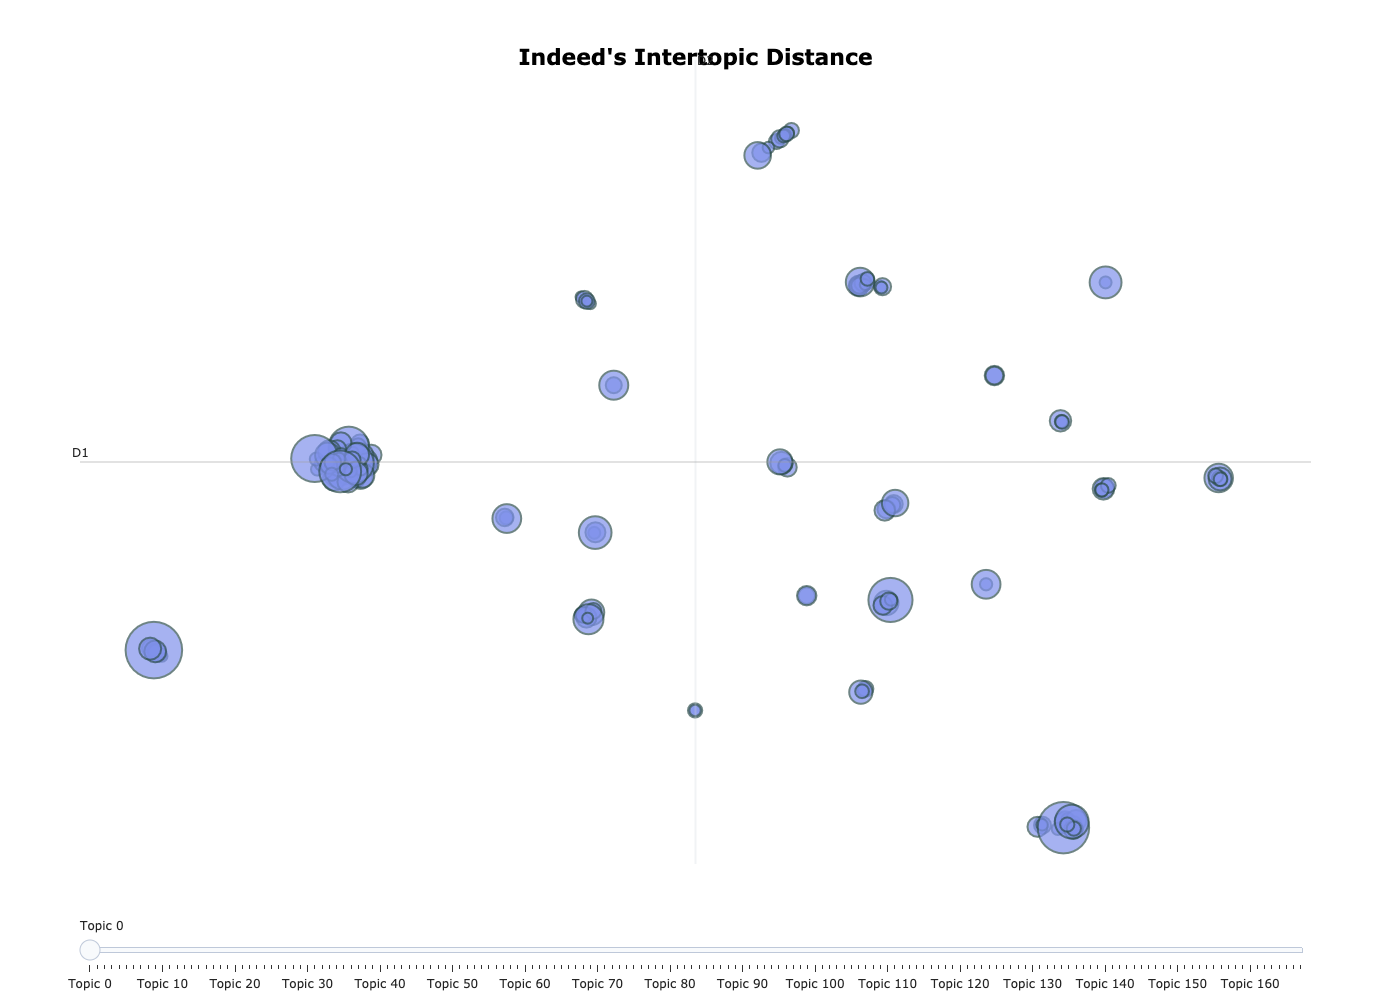

In [27]:
fig

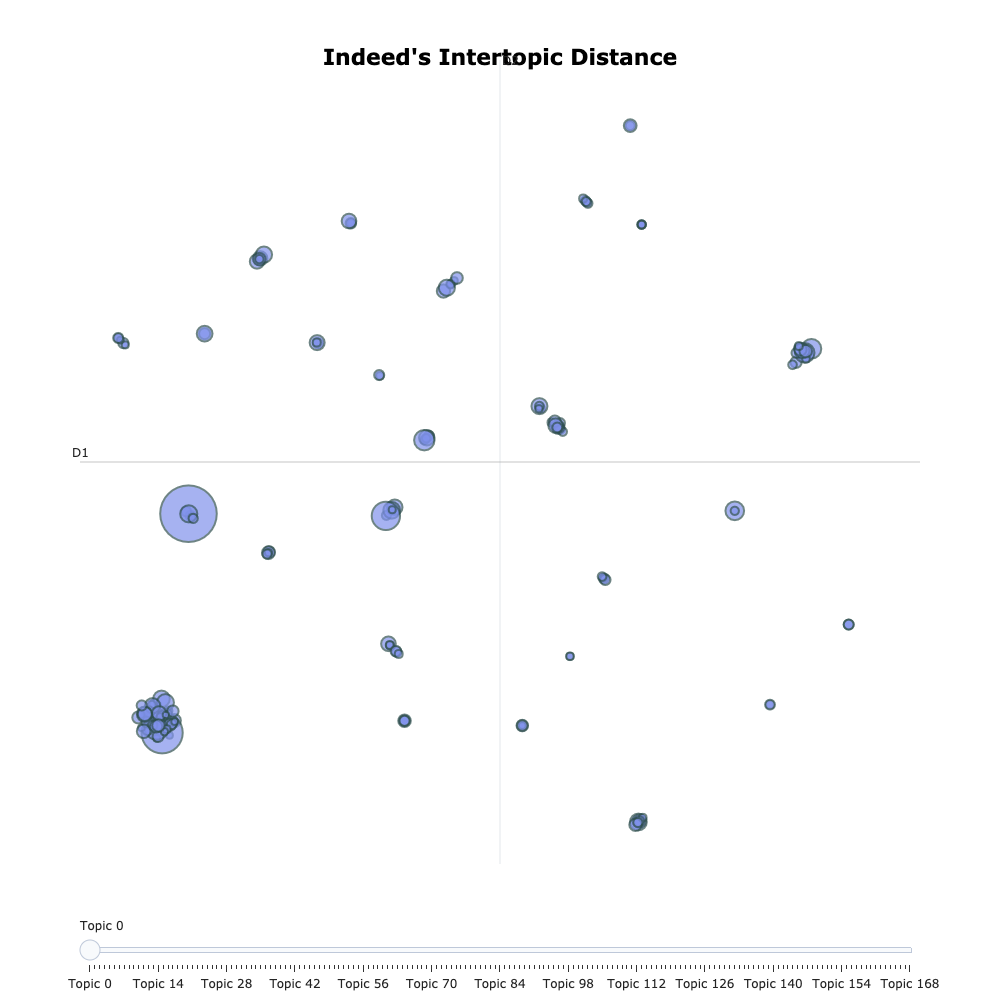

In [28]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (34).png") 

**Note: This figure is interactive, know plotly issue due to which the figure is not visible on Github.**

Topic Dendograms depicting the hierarchy of topics
--

In [28]:
def topics_dendrogram(embeddings, orientation="left", width = 1000, height = 1000):
    """
    Creates a Dendogram in topic space using sentence transformer embeddings
    """    
    embeddings = np.array(embeddings)
    topics_list = sorted(list(get_topics().keys()))
    topics_lookup = {topic:i for i, topic in enumerate(topics_list)}
    indices = np.array([topics_lookup[topic] for topic in topics_list])
    embeddings = embeddings[indices]

    # Create dendogram
    distance_matrix = 1 - cosine_similarity(embeddings)
    fig = ff.create_dendrogram(distance_matrix,
                               orientation=orientation,
                               linkagefun=lambda x: linkage(x, "ward"),
                               color_threshold=1)

    # Create nicer labels
    axis = "yaxis" if orientation == "left" else "xaxis"
    new_labels = [[[str(topics_list[int(x)]), None]] + get_topic(topics_list[int(x)])
                  for x in fig.layout[axis]["ticktext"]]
    new_labels = ["_".join([label[0] for label in labels[:4]]) for labels in new_labels]
    new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    # Stylize layout
    fig.update_layout(plot_bgcolor="#ECEFF1",
                      template="plotly_white",
                      title={'text': "<b>Indeed's Article Clustering", "y": .95, "x": 0.5, "xanchor": 'center', "yanchor": "top", "font": dict(size=22, color="Black")},
                      width=width,
                      height=height,
                      hoverlabel=dict(bgcolor="white", font_size=16,font_family="Rockwell"),

    )

    # Stylize orientation
    if orientation == "left":
        fig.update_layout(yaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    else:
        fig.update_layout(xaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    return fig

Create Topic embeddings
--

In [29]:
def create_topic_embeddings(embeddings):
    topic_list = list(get_topics().keys())
    topic_list.sort()
    topic_embeddings = []
    for i, topic in enumerate(topic_list):
        indexes = np.array(docs_df[docs_df["Topic"]==topic].index)
        topic_embedding = np.average(embeddings[indexes], axis=0)
        topic_embeddings.append(topic_embedding)
    return topic_embeddings

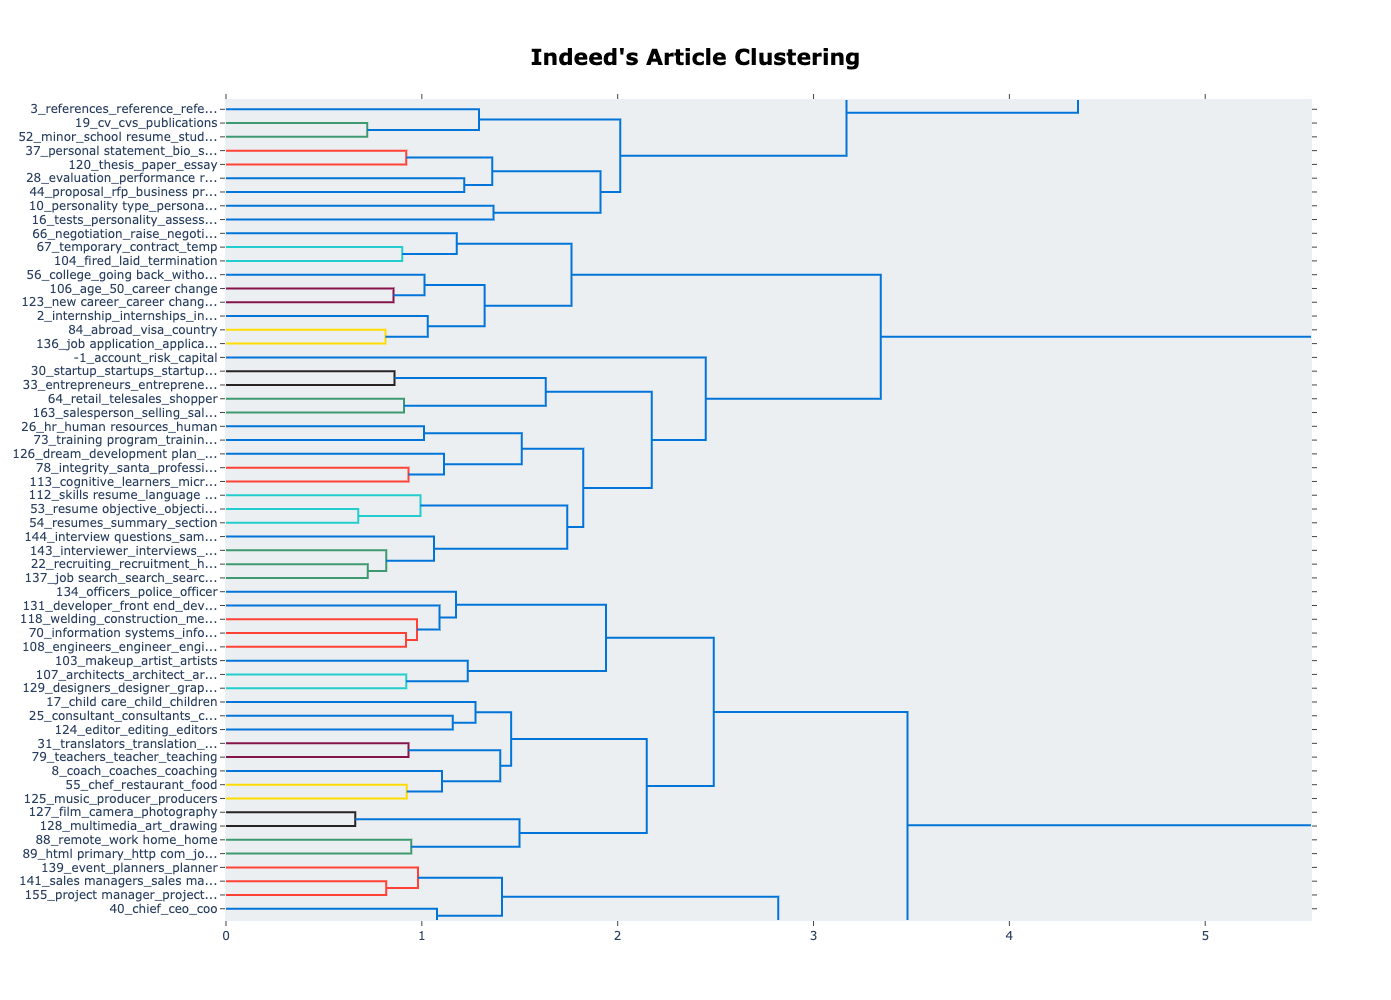

In [30]:
id_ = {len(np.unique(cluster.labels_))}
topic_embeddings_id_ = create_topic_embeddings(sent_embeddings)
fig = topics_dendrogram(embeddings=topic_embeddings_id_)
fig

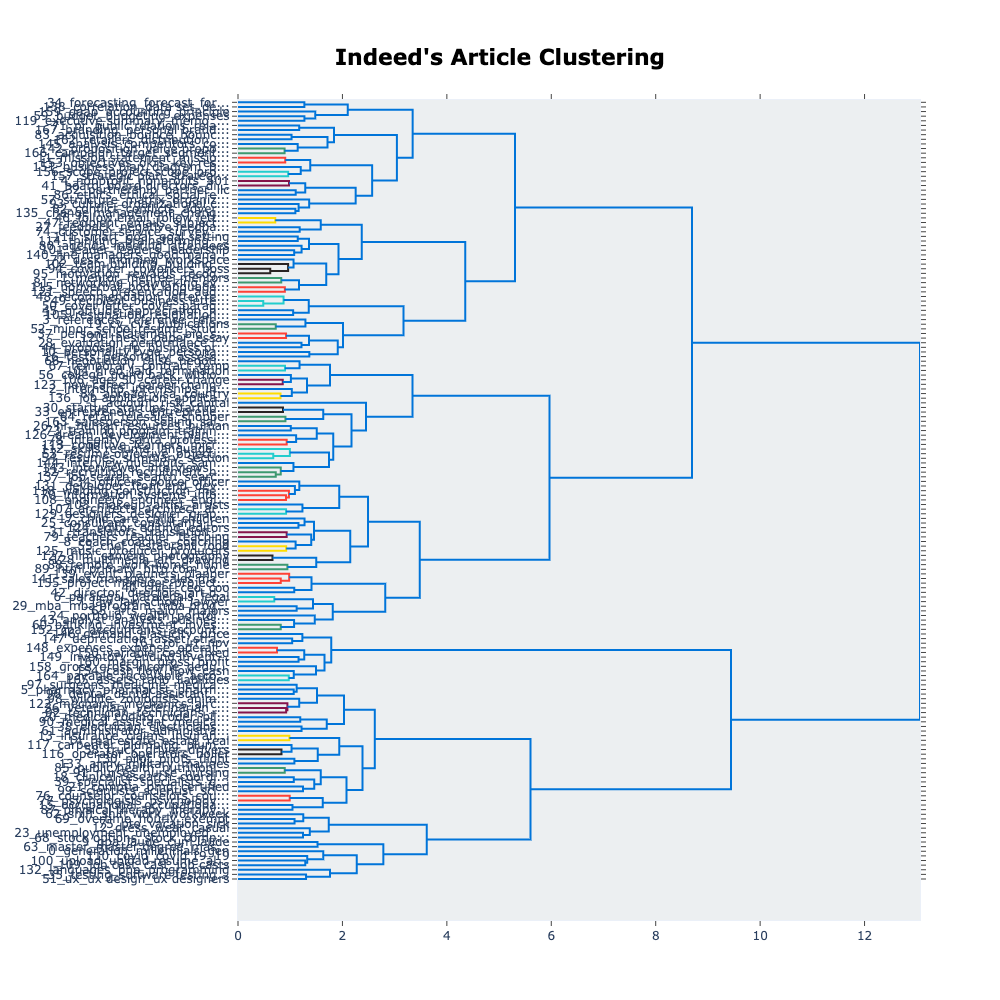

In [31]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (37).png") 

Zoomed in View
--

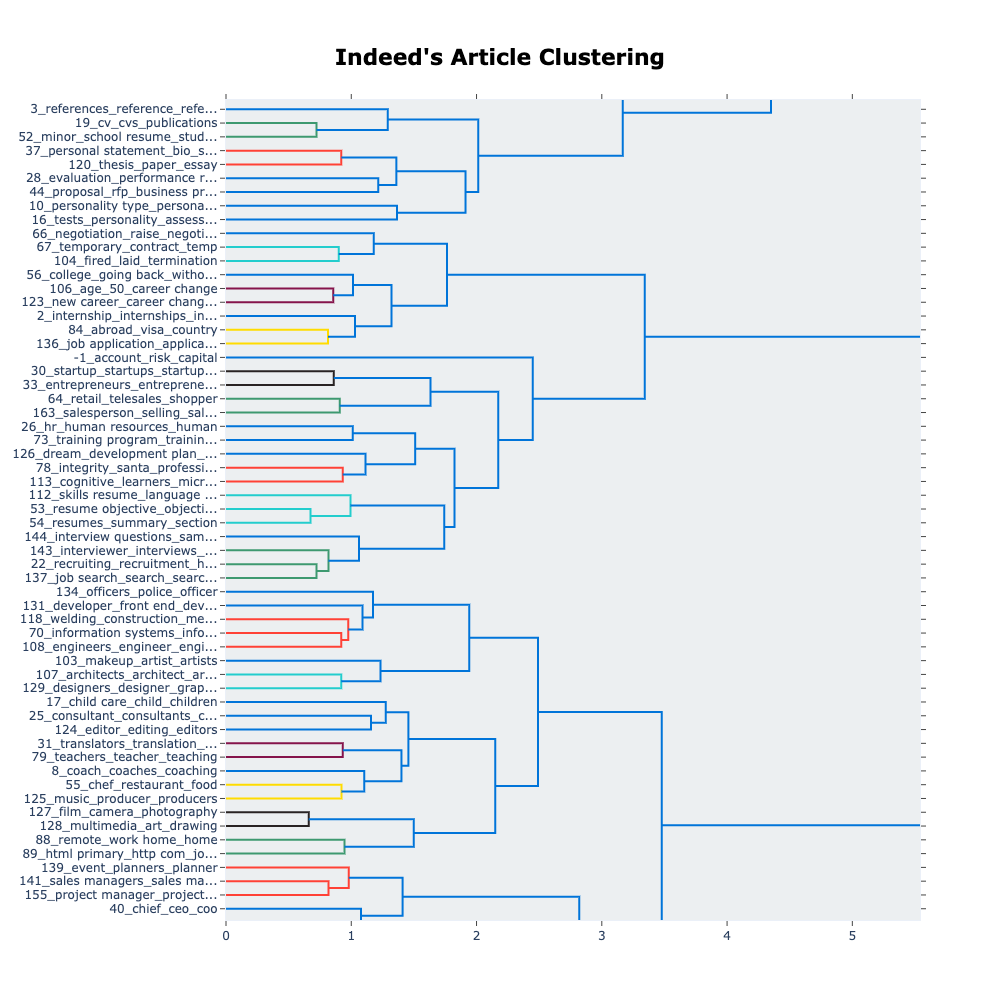

In [32]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (38).png") 

Merging Two Topic (if required)
--
**Note: Only run it if you know what topics to merge, otherwise skip it.** 
**Useful in the case when there are some topics which user wants then to be merged together.**

In [41]:
def merge_topics(topic_to_merge, topic_to_merge_into):
    """
    Merge the Topics if required
    """
    print(f"""
    Topic to be merged {topic_to_merge}:
    {top_10_words[topic_to_merge]}
    Topics to merge into {topic_to_merge_into}:
    {top_10_words[topic_to_merge_into]}
    \n
    """)

    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Title': ' '.join})
    m = len(content)
    tf_idf, count = doc_tf_idf(docs_per_topic.Title.values, m)
    top_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
    topic_sizes = get_topic_sizes(docs_df)
    return tf_idf, count, top_words, topic_sizes

tf_idf, count, top_10_words, topic_sizes = merge_topics(topic_to_merge=0,topic_to_merge_into=0)
topic_sizes.head(10)

New articles Predictions using Tf-IDF
--

In [33]:
content = list(art_test["cont_title"])
titles = list(art_test['contentTitle'])

In [34]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
test_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [35]:
test_embeddings.shape

torch.Size([1417, 384])

In [36]:
test_umap_embeddings = umap_model.transform(test_embeddings)

In [37]:
test_umap_embeddings.shape

(1417, 5)

In [38]:
predictions, probabilities = hdbscan.approximate_predict(hdbscan_model, test_umap_embeddings)
topic_distr = hdbscan.membership_vector(cluster, test_umap_embeddings)

Percentage distribution of Topic with respect to aricles
--

In [39]:
prediction_df = pd.DataFrame(titles, columns=["Title"])
prediction_df["Topic"] = predictions
prediction_df["Probabilities"] = probabilities
words_tfidf = [top_10_words[topic] for topic in predictions]
words = []
for word in words_tfidf:
    word_check = [w[0] for w in word]
    words.append(word_check)
prediction_df["Top_10_words"] = words

In [40]:
prediction_df[:20]

Title  Topic  \
0    How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1               What Is the Theory of Constraints and How Is It Used?     -1   
2       What Is Thinking Strategically? Definition and How To Improve     -1   
3       Thinking vs. Feeling in the Workplace: What's the Difference?     10   
4                                 17 Tips for Working With New Bosses    140   
5                     5 To-Do List Methods for Improving Productivity     72   
6                                      20 DevOps Tools and Their Uses    131   
7     6 of the Toughest Sales Interview Questions with Sample Answers    143   
8                 How To Train the Team: Team Training Types and Tips     73   
9                        What Are the Benefits of Six Sigma Training?     -1   
10                                  7 Types of Architectural Drawings    107   
11       A Guide to Bar Graphs and 6 Steps on How To Draw a Bar Graph    138   
12                             26 Types of Beams Used in Construction     -1   
13             4 Types of Confined Spaces You Might Encounter at Work     -1   
14  Algebraic Mathematical Equations: Definitions, Types and Examples    138   
15                          9 Types of Fiction Genres (With Examples)    124   
16                                         9 Types of Media Marketing    166   
17                                 The 4 Types of Nursing Assessments     91   
18                              13 Types of Phlebotomy Certifications     -1   
19                            19 Different Types of Psychology Majors     77   

    Probabilities  \
0        0.000000   
1        0.000000   
2        0.000000   
3        0.043121   
4        0.783114   
5        1.000000   
6        0.762296   
7        0.816981   
8        0.530904   
9        0.000000   
10       1.000000   
11       0.482318   
12       0.000000   
13       0.000000   
14       0.512269   
15       0.513763   
16       0.878952   
17       0.633387   
18       0.000000   
19       1.000000   

                                                                                                                                                                       Top_10_words  
0                                                                                                   [account, risk, capital, government, game, equity, call, tax, case, commission]  
1                                                                                                   [account, risk, capital, government, game, equity, call, tax, case, commission]  
2                                                                                                   [account, risk, capital, government, game, equity, call, tax, case, commission]  
3                                                                [personality type, personality, infps, briggs, myers, myers briggs, personality types, personalities, istj, intps]  
4                                             [line managers, good manager, new manager, city manager, management style, team members, managerial, macro, micromanager, front line]  
5                                                                         [desk, morning, workspace, productive, time management, task, distractions, productivity, breaks, stress]  
6                                                                                 [developer, front end, developers, coding, back end, web, front, code, web developer, full stack]  
7                                          [interviewer, interviews, interview questions, question, interviewers, interviewing, answers, job interview, candidate, phone interview]  
8   [training program, training needs, employee training, training development, training programs, hire training, needs assessment, cross training, new hire, development training]  
9                                                                                                   [account, risk, capit

In [44]:
prediction_df.to_csv(f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/approximate_predictions_{len(np.unique(cluster.labels_))}.csv")

Each Topic Distribution with respect to each article
--

In [38]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, title in enumerate(titles):
    for i in np.argsort(topic_distr[j],axis=0)[::-1][:10]:
        new_preds["Title"].append(title)
        words = top_10_words[i]
        check = []
        for word in words:
            check.append(word[0])
        new_preds["Perc"].append(round(topic_distr[j][i],5))
        new_preds["Top Words"].append(check)
        
prediction_df = pd.DataFrame.from_dict(new_preds)

In [39]:
prediction_df.iloc[:30]

Title     Perc  \
0   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.20466   
1   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.19225   
2   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.17410   
3   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.16440   
4   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
5   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
6   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
7   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
8   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
9   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00000   
10             What Is the Theory of Constraints and How Is It Used?  0.14665   
11             What Is the Theory of Constraints and How Is It Used?  0.00000   
12             What Is the Theory of Constraints and How Is It Used?  0.00000   
13             What Is the Theory of Constraints and How Is It Used?  0.00000   
14             What Is the Theory of Constraints and How Is It Used?  0.00000   
15             What Is the Theory of Constraints and How Is It Used?  0.00000   
16             What Is the Theory of Constraints and How Is It Used?  0.00000   
17             What Is the Theory of Constraints and How Is It Used?  0.00000   
18             What Is the Theory of Constraints and How Is It Used?  0.00000   
19             What Is the Theory of Constraints and How Is It Used?  0.00000   
20     What Is Thinking Strategically? Definition and How To Improve  0.37143   
21     What Is Thinking Strategically? Definition and How To Improve  0.07257   
22     What Is Thinking Strategically? Definition and How To Improve  0.06359   
23     What Is Thinking Strategically? Definition and How To Improve  0.00012   
24     What Is Thinking Strategically? Definition and How To Improve  0.00002   
25     What Is Thinking Strategically? Definition and How To Improve  0.00002   
26     What Is Thinking Strategically? Definition and How To Improve  0.00002   
27     What Is Thinking Strategically? Definition and How To Improve  0.00002   
28     What Is Thinking Strategically? Definition and How To Improve  0.00002   
29     What Is Thinking Strategically? Definition and How To Improve  0.00002   

                                                                                                                                                        Top Words  
0                                                                        [fired, termination, laid, quitting, quit, layoff, furlough, quit job, layoffs, leaving]  
1                               [relocation, relocation package, moving, package, relocation packages, relocate, moving expenses, relocating, move, new location]  
2                                                              [pto, vacation, sick, vacation time, days, policy, paid time, vacation days, sick days, unlimited]  
3                                                [resignation, resignation letter, leave, resign, maternity leave, maternity, notice, last day, leaving, absence]  
4                                                [work study, college, study, without degree, job college, fafsa, going back, midlevel, study jobs, back college]  
5                                        [team building, building activities, teamwork, teams, team members, together, virtual team, activity, building, virtual]  
6                      [culture, organizational culture, company culture, corporate culture, organizational, cultures, cultural, work culture, corporate, values]  
7                               [leader, leaders, leadership, leadership style, transformational, leadership skills, style, team members, transactional, servant]  
8                             [ethics, ethical, social responsibility, code

In [47]:
prediction_df.to_csv(f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/approximate_predictions_perc_distribution_{len(np.unique(cluster.labels_))}.csv")